In this notebook we explain how do we generate the volatility smile plot. 

At-the-money (ATM) options are the most liquid - we will look for the option with the strike price ($K$) closest to the forward value $F$, and treat this as the ATM option.

In an earlier notebook, we have covered how to compute implied volatility for a given option price.

Suppose $S=50$, $r=0.01$, $T=10.0$, and suppose the ATM volatility is $\sigma_{LN}=0.50$. Here the subscript "LN" stands for "lognormal".

In [48]:
import pandas
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt

In [49]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [50]:
def BachelierCall(S, K, r, sigma_N, T):
    d3 = (S-K) / (sigma_N*np.sqrt(T))
    return np.exp(-r * T) * ((S-K)*norm.cdf(d3) + sigma_N*np.sqrt(T)*norm.pdf(d3))

In [51]:
def impliedCallVolatility_BS(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                            BlackScholesCall(S, K, r, x, T),
                            1e-6, 1)
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [52]:
def impliedCallVolatility_Bachelier(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                            BachelierCall(S, K, r, x, T),
                            1e-6, 1)
    except Exception:
        impliedVol = np.nan

    return impliedVol

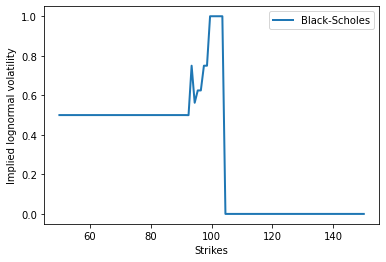

In [57]:
S = 50
r = 0.01
T = 10.0
sigma = 0.5
sigma_N = 0.5
F = S*np.exp(r*T)
strikes = np.linspace(50, 150, 100)

summary = []
for K in strikes:
#     price = BlackScholesCall(S, K, r, sigma, T)
    price = BachelierCall(S, K, r, sigma_N, T)
    impliedvol = impliedCallVolatility_Bachelier(S, K, r, price, T)
    summary.append([K, impliedvol])

df = pandas.DataFrame(summary, columns=['strike', 'vol'])
df.set_index('strike', drop=True, inplace=True)
plt.plot(df['vol'], linewidth=2.0, label='Black-Scholes')
# plt.axis([30, 170, 0.2, 0.6])
plt.legend()
plt.xlabel('Strikes')
plt.ylabel('Implied lognormal volatility')
plt.show()

Clearly, we get a flat surface, because we use the same lognormal volatility to price the options across all strikes. In other words, if the Black-Scholes' assumption that the stock price follows lognormal distribution with a constant variance, then we should expect the implied volatilities to be the same across all strikes.

For Bachelier model, suppose we use the model
\begin{equation*}
dS_t = \sigma_{N} S_0 dW_t 
\end{equation*}

As an exercise, you can try to generate the implied volatility curve using Bachelier model.

Next, let us try to simulate the price process under Black-Scholes and Bachelier Models. First we copy below the function covered in earlier sessions on the simulation of Brownian motion.

In [2]:
def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

We want to simulate a single path for:

  \begin{equation*}
    \begin{split}
      \mbox{Black-Scholes:} \;\;\;\;\; S_{t+\Delta t} &= S_t \exp\left[\left(r - \frac{\sigma^2}{2}\right) \Delta t + \sigma \cdot (W_{t+\Delta t} - W_t)\right] \\
      \mbox{Bachelier:} \;\;\;\;\; S_{t+\Delta t} &= S_t + \sigma \cdot (W_{t+\Delta t} - W_t)
    \end{split}
  \end{equation*}


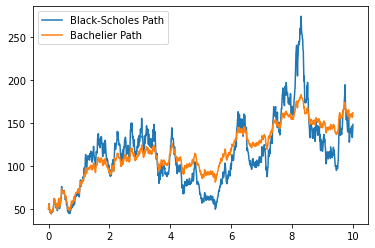

In [3]:
T, W_T = simulate_Brownian_Motion(1, 1000, 10.0)
blackscholespath = S*np.exp((r-sigma**2/2)*T + sigma*W_T)
bachelierpath = S + sigma*S*W_T
plt.plot(T, blackscholespath.T, label='Black-Scholes Path')
plt.plot(T, bachelierpath.T, label='Bachelier Path')
plt.legend()
plt.show()